In [64]:
import torch.nn as nn
import torch
import numpy as np

class ImagetoPatches(nn.Module):
    def __init__(self, image_size, patch_size): 
        super().__init__()
        self.image_size = image_size
        self.patch_size = patch_size 
        self.unfold = nn.Unfold(kernel_size=patch_size, stride=patch_size)
    def forward(self, x): 
        y = self.unfold(x)
        y = y.permute(0,2,1)
        return y 

In [65]:
from transformers import AutoImageProcessor, TFSegformerForSemanticSegmentation
from PIL import Image
import requests
import os 

In [66]:
path = os.path.join(os.getcwd(),"../../data/azh_wound_care_center_dataset_patches/train/images")

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
c:\Users\clshe\anaconda3\envs\adl_project\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


[1, 150, 128, 128]

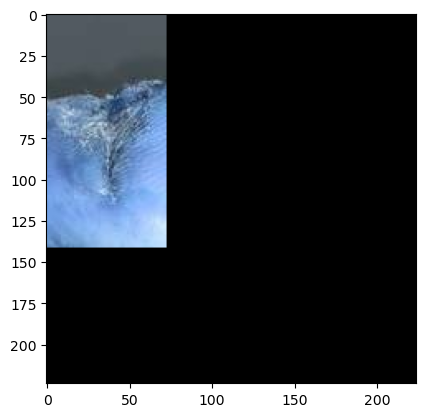

In [77]:
from transformers import AutoImageProcessor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt

image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")

image = cv2.imread("../../data/azh_wound_care_center_dataset_patches/train/images/0a5a3ada2bb75c4af2daf8e4726bf099_1.png")
plt.imshow(image)

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)
list(logits.shape)

In [92]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets

class GateModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GateModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

class ExpertModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(ExpertModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

class SparseMoEModel(nn.Module):
    def __init__(self, input_size, num_experts, num_classes):
        super(SparseMoEModel, self).__init__()
        self.experts = nn.ModuleList([ExpertModel(input_size, 64, num_classes) for _ in range(num_experts)])
        self.gate = GateModel(input_size, 64, num_experts)

    def forward(self, x):
        gate = self.gate(x)
        experts_outputs = [expert(x) for expert in self.experts]
        outputs = torch.sum(gate * torch.stack(experts_outputs, dim=1), dim=1)
        return outputs

# Define the input shape, number of experts, and number of classes
input_size = 256 * 256 * 3
num_experts = 3
num_classes = 21

# Define the data transform
transform = transforms.Compose([transforms.ToTensor()])

# Load the data
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)

# Define the input layer
inputs = torch.randn(1, input_size)

# Define the sparse mixture of experts model
model = SparseMoEModel(input_size, num_experts, num_classes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
for epoch in range(10):
    for data, target in train_loader:
        optimizer.zero_grad()
        data = data.view(-1, input_size)
        outputs = model(data)
        loss = criterion(outputs, target)
        loss.backward()
        optimizer.step()

100%|██████████| 170498071/170498071 [02:07<00:00, 1340734.75it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data


RuntimeError: shape '[-1, 196608]' is invalid for input of size 49152

In [89]:

predicted_segmentation_map = image_processor.post_process_semantic_segmentation(outputs, target_sizes=[(224,224)])[0]
predicted_segmentation_map = predicted_segmentation_map.cpu().numpy()

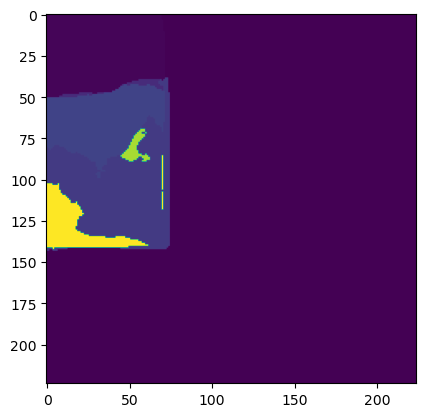

In [90]:
plt.imshow(predicted_segmentation_map)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
c:\Users\clshe\anaconda3\envs\adl_project\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


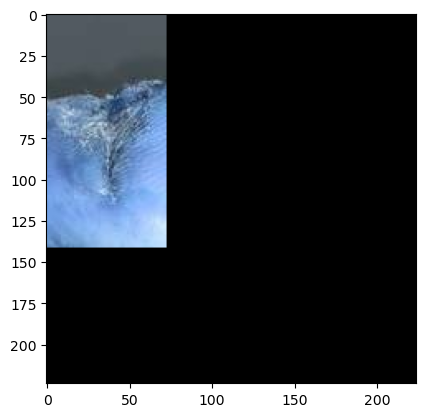

In [42]:
import matplotlib.pyplot as plt 
import cv2 

image = cv2.imread("../../data/azh_wound_care_center_dataset_patches/train/images/0a5a3ada2bb75c4af2daf8e4726bf099_1.png")
plt.imshow(image)
image_processor = AutoImageProcessor.from_pretrained("nvidia/segformer-b0-finetuned-ade-512-512")
processed_img = image_processor(image)["pixel_values"][0]

TypeError: view() takes from 0 to 2 positional arguments but 3 were given

In [6]:
i2p = ImagetoPatches((3,225,224),(3,16,16))
image = torch.rand(10,3,224,224)
print(image)

tensor([[[[0.4527, 0.6174, 0.5132,  ..., 0.7422, 0.0815, 0.5357],
          [0.4280, 0.6613, 0.7650,  ..., 0.6025, 0.6158, 0.4007],
          [0.1046, 0.4802, 0.2417,  ..., 0.3618, 0.4198, 0.6927],
          ...,
          [0.1518, 0.6972, 0.5938,  ..., 0.5029, 0.8028, 0.7411],
          [0.4162, 0.1160, 0.8193,  ..., 0.7278, 0.0725, 0.2693],
          [0.3263, 0.0435, 0.6695,  ..., 0.6501, 0.5986, 0.6632]],

         [[0.2253, 0.9468, 0.8636,  ..., 0.7355, 0.0969, 0.1132],
          [0.0728, 0.9568, 0.1752,  ..., 0.8808, 0.3985, 0.7855],
          [0.7403, 0.9949, 0.5115,  ..., 0.2670, 0.0665, 0.3761],
          ...,
          [0.2277, 0.6746, 0.7323,  ..., 0.9552, 0.8554, 0.1663],
          [0.3379, 0.8392, 0.8064,  ..., 0.6407, 0.0884, 0.9205],
          [0.0437, 0.2096, 0.3130,  ..., 0.8699, 0.8873, 0.9255]],

         [[0.9539, 0.6568, 0.9782,  ..., 0.1531, 0.8541, 0.5912],
          [0.5746, 0.4623, 0.0893,  ..., 0.2154, 0.7304, 0.6632],
          [0.8906, 0.9308, 0.9236,  ..., 0

In [7]:
patches = i2p(image)
patches.shape

RuntimeError: It is expected kernel_size equals to 2, but got size 3

In [22]:
import torch
from einops import rearrange
from torch import nn

class LayerNorm2d(nn.LayerNorm):
    def forward(self, x):
        x = rearrange(x, "b c h w -> b h w c")
        x = super().forward(x)
        x = rearrange(x, "b h w c -> b c h w")
        return x
    

class OverlapPatchMerging(nn.Sequential):
    def __init__(
        self, in_channels: int, out_channels: int, patch_size: int, overlap_size: int
    ):
        super().__init__(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=patch_size,
                stride=overlap_size,
                padding=patch_size // 2,
                bias=False
            ),
            LayerNorm2d(out_channels)
        )

r = 4
channels = 8
x = torch.randn((1, channels, 64, 64))
_, _, h, w = x.shape
# we want a vector of shape 1, 8, 32, 32
x = rearrange(x, "b c h w -> b (h w) c") # shape = [1, 4096, 8]
x = rearrange(x, "b (hw r) c -> b hw (c r)", r=r) # shape = [1, 1024, 32]
reducer = nn.Linear(channels*r, channels)
x = reducer(x) # shape = [1, 1024, 8]
half_r = r // 2
x = rearrange(x, "b (h w) c -> b c h w", h=h//half_r) # shape = [1, 8, 32, 32]

class EfficientMultiHeadAttention(nn.Module):
    def __init__(self, channels: int, reduction_ratio: int = 1, num_heads: int = 8):
        super().__init__()
        self.reducer = nn.Sequential(
            nn.Conv2d(
                channels, channels, kernel_size=reduction_ratio, stride=reduction_ratio
            ),
            LayerNorm2d(channels),
        )
        self.att = nn.MultiheadAttention(
            channels, num_heads=num_heads, batch_first=True
        )

    def forward(self, x):
        _, _, h, w = x.shape
        reduced_x = self.reducer(x)
        # attention needs tensor of shape (batch, sequence_length, channels)
        reduced_x = rearrange(reduced_x, "b c h w -> b (h w) c")
        x = rearrange(x, "b c h w -> b (h w) c")
        print("X shape: ", x.shape, "Reduced X shape: ", reduced_x.shape)
        out = self.att(x, reduced_x, reduced_x)[0]
        # print(out)
        # reshape it back to (batch, channels, height, width)
        out = rearrange(out, "b (h w) c -> b c h w", h=h, w=w)
        return out
    
x = torch.randn((1, channels, 64, 64))
block = EfficientMultiHeadAttention(channels, reduction_ratio=r)
block(x).shape

class MixMLP(nn.Sequential):
    def __init__(self, channels: int, expansion: int = 4):
        super().__init__(
            # dense layer
            nn.Conv2d(channels, channels, kernel_size=1),
            # depth wise conv
            nn.Conv2d(
                channels,
                channels * expansion,
                kernel_size=3,
                groups=channels,
                padding=1,
            ),
            nn.GELU(),
            # dense layer
            nn.Conv2d(channels * expansion, channels, kernel_size=1),
        )


X shape:  torch.Size([1, 4096, 8]) Reduced X shape:  torch.Size([1, 256, 8])


In [23]:
from torchvision.ops import StochasticDepth

class ResidualAdd(nn.Module):
    """Just an util layer"""
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, **kwargs):
        out = self.fn(x, **kwargs)
        x = x + out
        return x

class SegFormerEncoderBlock(nn.Sequential):
    def __init__(
        self,
        channels: int,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
        drop_path_prob: float = .0
    ):
        super().__init__(
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    EfficientMultiHeadAttention(channels, reduction_ratio, num_heads),
                )
            ),
            ResidualAdd(
                nn.Sequential(
                    LayerNorm2d(channels),
                    MixMLP(channels, expansion=mlp_expansion),
                    StochasticDepth(p=drop_path_prob, mode="batch")
                )
            ),
        )


x = torch.randn((1, channels, 64, 64))
block = SegFormerEncoderBlock(channels, reduction_ratio=r)
block(x).shape

from typing import List

class SegFormerEncoderStage(nn.Sequential):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        patch_size: int,
        overlap_size: int,
        drop_probs: List[int],
        depth: int = 2,
        reduction_ratio: int = 1,
        num_heads: int = 8,
        mlp_expansion: int = 4,
    ):
        super().__init__()
        self.overlap_patch_merge = OverlapPatchMerging(
            in_channels, out_channels, patch_size, overlap_size,
        )
        self.blocks = nn.Sequential(
            *[
                SegFormerEncoderBlock(
                    out_channels, reduction_ratio, num_heads, mlp_expansion, drop_probs[i]
                )
                for i in range(depth)
            ]
        )
        self.norm = LayerNorm2d(out_channels)

from typing import Iterable

def chunks(data: Iterable, sizes: List[int]):
    """
    Given an iterable, returns slices using sizes as indices
    """
    curr = 0
    for size in sizes:
        chunk = data[curr: curr + size]
        curr += size
        yield chunk
        
class SegFormerEncoder(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        drop_prob: float = .0
    ):
        super().__init__()
        # create drop paths probabilities (one for each stage's block)
        drop_probs =  [x.item() for x in torch.linspace(0, drop_prob, sum(depths))]
        self.stages = nn.ModuleList(
            [
                SegFormerEncoderStage(*args)
                for args in zip(
                    [in_channels, *widths],
                    widths,
                    patch_sizes,
                    overlap_sizes,
                    chunks(drop_probs, sizes=depths),
                    depths,
                    reduction_ratios,
                    all_num_heads,
                    mlp_expansions
                )
            ]
        )
        
    def forward(self, x):
        features = []
        for stage in self.stages:
            x = stage(x)
            features.append(x)
        return features

class SegFormerDecoderBlock(nn.Sequential):
    def __init__(self, in_channels: int, out_channels: int, scale_factor: int = 2):
        super().__init__(
            nn.UpsamplingBilinear2d(scale_factor=scale_factor),
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
        )

class SegFormerDecoder(nn.Module):
    def __init__(self, out_channels: int, widths: List[int], scale_factors: List[int]):
        super().__init__()
        self.stages = nn.ModuleList(
            [
                SegFormerDecoderBlock(in_channels, out_channels, scale_factor)
                for in_channels, scale_factor in zip(widths, scale_factors)
            ]
        )
    
    def forward(self, features):
        new_features = []
        for feature, stage in zip(features,self.stages):
            x = stage(feature)
            new_features.append(x)
        return new_features
    
class SegFormerSegmentationHead(nn.Module):
    def __init__(self, channels: int, num_classes: int, num_features: int = 4):
        super().__init__()
        self.fuse = nn.Sequential(
            nn.Conv2d(channels * num_features, channels, kernel_size=1, bias=False),
            nn.ReLU(), # why relu? Who knows
            nn.BatchNorm2d(channels) # why batchnorm and not layer norm? Idk
        )
        self.predict = nn.Conv2d(channels, num_classes, kernel_size=1)

    def forward(self, features):
        x = torch.cat(features, dim=1)
        x = self.fuse(x)
        x = self.predict(x)
        return x

X shape:  torch.Size([1, 4096, 8]) Reduced X shape:  torch.Size([1, 256, 8])


In [24]:
class SegFormer(nn.Module):
    def __init__(
        self,
        in_channels: int,
        widths: List[int],
        depths: List[int],
        all_num_heads: List[int],
        patch_sizes: List[int],
        overlap_sizes: List[int],
        reduction_ratios: List[int],
        mlp_expansions: List[int],
        decoder_channels: int,
        scale_factors: List[int],
        num_classes: int,
        drop_prob: float = 0.0,
    ):

        super().__init__()
        self.encoder = SegFormerEncoder(
            in_channels,
            widths,
            depths,
            all_num_heads,
            patch_sizes,
            overlap_sizes,
            reduction_ratios,
            mlp_expansions,
            drop_prob,
        )
        self.decoder = SegFormerDecoder(decoder_channels, widths[::-1], scale_factors)
        self.head = SegFormerSegmentationHead(
            decoder_channels, num_classes, num_features=len(widths)
        )

    def forward(self, x):
        features = self.encoder(x)
        features = self.decoder(features[::-1])
        segmentation = self.head(features)
        return segmentation

In [27]:
segformer = SegFormer(
    in_channels=3,
    widths=[64, 128, 256, 512],
    depths=[3, 4, 6, 3],
    all_num_heads=[1, 2, 4, 8],
    patch_sizes=[7, 3, 3, 3],
    overlap_sizes=[4, 2, 2, 2],
    reduction_ratios=[8, 4, 2, 1],
    mlp_expansions=[4, 4, 4, 4],
    decoder_channels=256,
    scale_factors=[8, 4, 2, 1],
    num_classes=1,
)

segmentation = segformer(torch.randn((8, 3, 224, 224)))
segmentation.shape # torch.Size([1, 100, 56, 56])

X shape:  torch.Size([8, 3136, 64]) Reduced X shape:  torch.Size([8, 49, 64])
X shape:  torch.Size([8, 3136, 64]) Reduced X shape:  torch.Size([8, 49, 64])
X shape:  torch.Size([8, 3136, 64]) Reduced X shape:  torch.Size([8, 49, 64])
X shape:  torch.Size([8, 784, 128]) Reduced X shape:  torch.Size([8, 49, 128])
X shape:  torch.Size([8, 784, 128]) Reduced X shape:  torch.Size([8, 49, 128])
X shape:  torch.Size([8, 784, 128]) Reduced X shape:  torch.Size([8, 49, 128])
X shape:  torch.Size([8, 784, 128]) Reduced X shape:  torch.Size([8, 49, 128])
X shape:  torch.Size([8, 196, 256]) Reduced X shape:  torch.Size([8, 49, 256])
X shape:  torch.Size([8, 196, 256]) Reduced X shape:  torch.Size([8, 49, 256])
X shape:  torch.Size([8, 196, 256]) Reduced X shape:  torch.Size([8, 49, 256])
X shape:  torch.Size([8, 196, 256]) Reduced X shape:  torch.Size([8, 49, 256])
X shape:  torch.Size([8, 196, 256]) Reduced X shape:  torch.Size([8, 49, 256])
X shape:  torch.Size([8, 196, 256]) Reduced X shape:  t

torch.Size([8, 1, 56, 56])

In [26]:
import matplotlib.pyplot as plt
torch.segmentation

AttributeError: module 'torch' has no attribute 'segmentation'

In [8]:
import einops 
import torch 

tensors = torch.rand(8, 3, 224, 224)
tensors = einops.rearrange(tensors, "b c h w -> b (h w) c")
tensors.shape

torch.Size([8, 50176, 3])